In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm

In [298]:
path_train = r"../train/"

In [318]:
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()

dislok.fillna(pd.NA, inplace=True)

In [300]:
dislok.shape

(6250933, 16)

In [301]:
target_df = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
target_df['month'] = pd.to_datetime(target_df['month'])
target_df.sample(5)

,wagnum,month,target_month,target_day
15320,33553,2023-01-01,0,0
141273,22909,2022-11-01,0,0
155111,20532,2022-11-01,0,0
87399,24036,2022-09-01,0,0
174785,20755,2022-12-01,0,0


In [302]:
target_df.target_month.mean()

0.0510220600138335

### Дислокация вагонов - сбор данных

In [303]:
dislok.columns

Index(['plan_date', 'wagnum', 'date_kap', 'date_dep', 'kod_vrab',
       'date_pl_rem', 'id_road_disl', 'st_id_dest', 'id_road_dest',
       'st_id_send', 'id_road_send', 'ost_prob', 'isload', 'fr_id',
       'last_fr_id', 'distance'],
      dtype='object')

In [304]:
import gc
gc.collect()

1378

In [305]:
dislok['days_to_pl_rem'] = (dislok['date_pl_rem'] - dislok['plan_date']).dt.days
dislok['another_road'] = dislok['id_road_dest'] != dislok['id_road_send']
dislok['last_rem_date'] = dislok[['date_kap', 'date_dep']].max(axis=1)
dislok['days_from_last_rem'] = (dislok['plan_date'] - dislok['last_rem_date']).dt.days
dislok = dislok.convert_dtypes()

In [306]:
dislok.sort_values(by='plan_date', inplace=True)

In [307]:
to_fill = ['ost_prob']

dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(method='ffill'))
dislok[to_fill] = dislok.groupby('wagnum')[to_fill].transform(lambda x: x.fillna(0))

In [308]:
dislok.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6250933 entries, 0 to 1052924
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   plan_date           datetime64[us]
 1   wagnum              Int64         
 2   date_kap            datetime64[us]
 3   date_dep            datetime64[us]
 4   kod_vrab            Int64         
 5   date_pl_rem         datetime64[us]
 6   id_road_disl        Int64         
 7   st_id_dest          Int64         
 8   id_road_dest        Int64         
 9   st_id_send          Int64         
 10  id_road_send        Int64         
 11  ost_prob            Int64         
 12  isload              Int64         
 13  fr_id               Int64         
 14  last_fr_id          Int64         
 15  distance            Int64         
 16  days_to_pl_rem      Int64         
 17  another_road        boolean       
 18  last_rem_date       datetime64[us]
 19  days_from_last_rem  Int64         
dtypes: Int6

In [309]:
wagnum_subtables = {wagnum: table for wagnum, table in tqdm(dislok.groupby('wagnum'))}

  0%|          | 0/33977 [00:00<?, ?it/s]

In [310]:
from itertools import product

intervals = [pd.DateOffset(days=10), pd.DateOffset(days=30), pd.DateOffset(days=90)]
functions = {"isload": ['mean'], "ost_prob": ['min', 'max']}
take_last_cols = ['date_kap', 'date_dep', 'kod_vrab', 'date_pl_rem', 'days_to_pl_rem', 'last_rem_date', 'days_from_last_rem', 'ost_prob']
rolling_cols = set()


for wagnum, table in tqdm(wagnum_subtables.items()):
    for interval in intervals:
        for col, func_list in functions.items():
            for func in func_list:
                table[f"{interval.days}d_{col}_{func}"] = getattr(table[col].rolling(interval.days), func)(engine='numba')
                rolling_cols.add(f"{interval.days}d_{col}_{func}")

for wagnum, table in tqdm(wagnum_subtables.items()):
    table['10d_ost_prob_sum'] = table['10d_ost_prob_max'] - table['10d_ost_prob_min']
    table['30d_ost_prob_sum'] = table['30d_ost_prob_max'] - table['30d_ost_prob_min']
    table['90d_ost_prob_sum'] = table['90d_ost_prob_max'] - table['90d_ost_prob_min']
    table['10d_prob_mean'] = table['10d_ost_prob_sum'] / 10
    table['30d_prob_mean'] = table['30d_ost_prob_sum'] / 30
    table['90d_prob_mean'] = table['90d_ost_prob_sum'] / 90

for newcol in ['10d_prob_mean', '30d_prob_mean', '90d_prob_mean', '10d_ost_prob_sum', '30d_ost_prob_sum', '90d_ost_prob_sum']:
    rolling_cols.add(newcol)

columns_to_add = list(rolling_cols) + take_last_cols

  0%|          | 0/33977 [00:00<?, ?it/s]

  0%|          | 0/33977 [00:00<?, ?it/s]

In [312]:
wagnum_subtables[0][['plan_date', '30d_ost_prob_min', '30d_ost_prob_max', '30d_prob_mean', '30d_ost_prob_sum']].sample(10)

,plan_date,30d_ost_prob_min,30d_ost_prob_max,30d_prob_mean,30d_ost_prob_sum
67216,2022-09-17,70682.0,80036.0,311.800000,9354.0
525660,2022-11-01,68881.0,68931.0,1.666667,50.0
414373,2022-10-24,68931.0,70495.0,52.133333,1564.0
414379,2022-10-30,68881.0,69876.0,33.166667,995.0
414363,2022-10-14,68931.0,70682.0,58.366667,1751.0
525664,2022-11-05,68881.0,68931.0,1.666667,50.0
459643,2022-12-31,57742.0,63071.0,177.633333,5329.0
67205,2022-09-06,72966.0,80930.0,265.466667,7964.0
525674,2022-11-15,65204.0,68931.0,124.233333,3727.0
67228,2022-09-29,69876.0,75322.0,181.533333,5446.0


In [313]:
columns_to_add

['10d_ost_prob_max',
 '30d_ost_prob_sum',
 '30d_prob_mean',
 '90d_isload_mean',
 '90d_prob_mean',
 '90d_ost_prob_min',
 '90d_ost_prob_sum',
 '10d_ost_prob_sum',
 '10d_ost_prob_min',
 '10d_prob_mean',
 '30d_ost_prob_max',
 '30d_isload_mean',
 '10d_isload_mean',
 '90d_ost_prob_max',
 '30d_ost_prob_min',
 'date_kap',
 'date_dep',
 'kod_vrab',
 'date_pl_rem',
 'days_to_pl_rem',
 'last_rem_date',
 'days_from_last_rem',
 'ost_prob']

In [314]:
target_df.sort_values(by=['month', 'wagnum'], inplace=True)

data = pd.concat([wagnum_subtables[wagnum] for wagnum in tqdm(wagnum_subtables.keys())])
data = data[columns_to_add + ['wagnum', 'plan_date']]
data.rename({'plan_date': 'month'}, axis=1, inplace=True)
target_df_new = target_df.merge(data, on=['month', 'wagnum'], how='left')
    

target_df_new.sample(5)

  0%|          | 0/33977 [00:00<?, ?it/s]

,wagnum,month,target_month,target_day,10d_ost_prob_max,30d_ost_prob_sum,30d_prob_mean,90d_isload_mean,90d_prob_mean,90d_ost_prob_min,...,90d_ost_prob_max,30d_ost_prob_min,date_kap,date_dep,kod_vrab,date_pl_rem,days_to_pl_rem,last_rem_date,days_from_last_rem,ost_prob
30631,30632,2022-08-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,2021-06-03,1,2024-06-03,672,2021-06-03,424,69291
174974,5093,2023-01-01,0,0,25349.0,6505.0,216.833333,0.477778,210.888889,24944.0,...,43924.0,24944.0,NaT,2020-04-04,0,2023-04-04,93,2020-04-04,1002,24944
98448,30497,2022-10-01,0,0,159999.0,160008.0,5333.600000,NaN,NaN,NaN,...,NaN,-9.0,NaT,2020-04-21,1,2023-04-21,202,2020-04-21,893,159999
147504,11600,2022-12-01,0,0,69593.0,2521.0,84.033333,0.477778,144.700000,69191.0,...,82214.0,69191.0,2019-08-11,2021-08-05,0,2024-08-05,613,2021-08-05,483,69191
14267,14268,2022-08-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2015-11-06,2020-05-11,0,2023-05-11,283,2020-05-11,812,27187


In [315]:
target_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203854 entries, 0 to 203853
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wagnum              203854 non-null  Int64         
 1   month               203854 non-null  datetime64[ns]
 2   target_month        203854 non-null  Int64         
 3   target_day          203854 non-null  Int64         
 4   10d_ost_prob_max    169870 non-null  float64       
 5   30d_ost_prob_sum    169861 non-null  float64       
 6   30d_prob_mean       169861 non-null  float64       
 7   90d_isload_mean     101910 non-null  float64       
 8   90d_prob_mean       101910 non-null  float64       
 9   90d_ost_prob_min    101910 non-null  float64       
 10  90d_ost_prob_sum    101910 non-null  float64       
 11  10d_ost_prob_sum    169870 non-null  float64       
 12  10d_ost_prob_min    169870 non-null  float64       
 13  10d_prob_mean       169870 no

In [322]:
target_df_new.month.unique()

<DatetimeArray>
['2022-08-01 00:00:00', '2022-09-01 00:00:00', '2022-10-01 00:00:00',
 '2022-11-01 00:00:00', '2022-12-01 00:00:00', '2023-01-01 00:00:00']
Length: 6, dtype: datetime64[ns]

### Тип владения вагоном - сбор данных

In [328]:
wag_prob_months.dtypes

month             datetime64[us]
wagnum                     Int64
manage_type                Int64
rod_id                     Int64
reestr_state               Int64
ownership_type             Int64
dtype: object

In [326]:
target_df_new.dtypes

wagnum                         Int64
month                 datetime64[ns]
target_month                   Int64
target_day                     Int64
10d_ost_prob_max             float64
30d_ost_prob_sum             float64
30d_prob_mean                float64
90d_isload_mean              float64
90d_prob_mean                float64
90d_ost_prob_min             float64
90d_ost_prob_sum             float64
10d_ost_prob_sum             float64
10d_ost_prob_min             float64
10d_prob_mean                float64
30d_ost_prob_max             float64
30d_isload_mean              float64
10d_isload_mean              float64
90d_ost_prob_max             float64
30d_ost_prob_min             float64
date_kap              datetime64[us]
date_dep              datetime64[us]
kod_vrab                       Int64
date_pl_rem           datetime64[us]
days_to_pl_rem                 Int64
last_rem_date         datetime64[us]
days_from_last_rem             Int64
ost_prob                       Int64
d

In [331]:
wag_prob_months = wag_prob[wag_prob.repdate.dt.day == 1].copy()
print(wag_prob_months.shape)

wag_prob_months.drop(['ost_prob', 'month'], axis=1, inplace=True)
wag_prob_months.rename({'repdate': 'month'}, axis=1, inplace=True)

target_df_new_ = target_df_new.merge(wag_prob_months, on=['month', 'wagnum'], how='left')
target_df_new_.sample(5)

(203852, 8)


,wagnum,month,target_month,target_day,10d_ost_prob_max,30d_ost_prob_sum,30d_prob_mean,90d_isload_mean,90d_prob_mean,90d_ost_prob_min,...,kod_vrab,date_pl_rem,days_to_pl_rem,last_rem_date,days_from_last_rem,ost_prob,manage_type,rod_id,reestr_state,ownership_type
116543,14616,2022-11-01,0,0,160000.0,130842.0,4361.400000,0.477778,1453.800000,29158.0,...,0,2023-10-02,335,2020-10-02,760,29158,0,1,1,0
107337,5410,2022-11-01,0,0,66331.0,3573.0,119.100000,0.444444,115.511111,65838.0,...,0,2023-08-24,296,2020-08-24,799,65838,0,0,1,0
115194,13267,2022-11-01,0,0,143753.0,12098.0,403.266667,0.488889,1743.666667,3070.0,...,0,2023-07-20,261,2020-07-20,834,142042,0,1,1,0
179379,9499,2023-01-01,0,0,68249.0,4078.0,135.933333,0.566667,161.200000,64592.0,...,1,2024-07-30,576,2021-07-30,520,64592,0,0,1,0
50185,16210,2022-09-01,0,0,134692.0,0.0,0.000000,NaN,NaN,NaN,...,0,2025-03-06,917,2022-03-06,179,134692,0,0,1,0


In [332]:
target_df_new_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203854 entries, 0 to 203853
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wagnum              203854 non-null  Int64         
 1   month               203854 non-null  datetime64[ns]
 2   target_month        203854 non-null  Int64         
 3   target_day          203854 non-null  Int64         
 4   10d_ost_prob_max    169870 non-null  float64       
 5   30d_ost_prob_sum    169861 non-null  float64       
 6   30d_prob_mean       169861 non-null  float64       
 7   90d_isload_mean     101910 non-null  float64       
 8   90d_prob_mean       101910 non-null  float64       
 9   90d_ost_prob_min    101910 non-null  float64       
 10  90d_ost_prob_sum    101910 non-null  float64       
 11  10d_ost_prob_sum    169870 non-null  float64       
 12  10d_ost_prob_min    169870 non-null  float64       
 13  10d_prob_mean       169870 no

In [333]:
target_df_new = target_df_new_

### Характеристики вагонов - обзор данных

In [94]:
wag_param.columns

Index(['wagnum', 'model', 'rod_id', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build',
       'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega',
       'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype'],
      dtype='object')

In [336]:
target_df_new = target_df_new.merge(wag_param, on=['wagnum'], how='left')
target_df_new.sample(5)

,wagnum,month,target_month,target_day,10d_ost_prob_max,30d_ost_prob_sum,30d_prob_mean,90d_isload_mean,90d_prob_mean,90d_ost_prob_min,...,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
195361,25481,2023-01-01,0,0,158057.0,158555.0,5285.166667,0.355556,1761.722222,1444.0,...,NaT,110,160,22,2,2,7,11,160000,0
29344,29345,2022-08-01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,110,160,2,9,2,7,11,160000,0
141554,5650,2022-12-01,1,0,8426.0,4455.0,148.500000,0.477778,173.333333,5563.0,...,NaT,110,160,2,9,3,1,12,110000,0
51760,17785,2022-09-01,0,0,95672.0,6080.0,202.666667,NaN,NaN,NaN,...,NaT,110,160,2,9,2,7,11,160000,0
42209,8234,2022-09-01,0,0,112321.0,1075.0,35.833333,NaN,NaN,NaN,...,NaT,110,160,2,9,2,1,2,160000,0


In [337]:
target_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203854 entries, 0 to 203853
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wagnum              203854 non-null  Int64         
 1   month               203854 non-null  datetime64[ns]
 2   target_month        203854 non-null  Int64         
 3   target_day          203854 non-null  Int64         
 4   10d_ost_prob_max    169870 non-null  float64       
 5   30d_ost_prob_sum    169861 non-null  float64       
 6   30d_prob_mean       169861 non-null  float64       
 7   90d_isload_mean     101910 non-null  float64       
 8   90d_prob_mean       101910 non-null  float64       
 9   90d_ost_prob_min    101910 non-null  float64       
 10  90d_ost_prob_sum    101910 non-null  float64       
 11  10d_ost_prob_sum    169870 non-null  float64       
 12  10d_ost_prob_min    169870 non-null  float64       
 13  10d_prob_mean       169870 no

<Axes: ylabel='Frequency'>

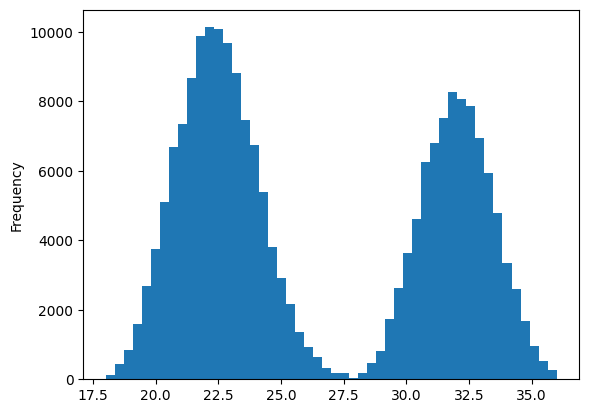

In [339]:
target_df_new['expected_srok_sl_y'] = (target_df_new['srok_sl'] - target_df_new['date_build']).dt.days / 365
target_df_new['expected_srok_sl_y'].plot.hist(bins=50, range=(18, 36))

In [340]:
target_df_new['expected_srok_sl_y_b'] = target_df_new['expected_srok_sl_y'].apply(lambda x: "short" if x <= 27.5 else "long")
target_df_new['expected_srok_sl_y_b'].value_counts()

expected_srok_sl_y_b
short    117834
long      86020
Name: count, dtype: int64

In [341]:
target_df_new['date_build_b'] = pd.cut(target_df_new['date_build'].dt.year, bins=[0, 2000, 2007, 2017, 2030])
target_df_new['date_build_b'].value_counts()

date_build_b
(2007, 2017]    125342
(0, 2000]        32037
(2000, 2007]     31451
(2017, 2030]     15024
Name: count, dtype: int64

In [343]:
target_df_new.to_csv(path_train + '/data/first_3_tables.csv', index=False)